# Same as in 19_01 but context 4

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import algorithms
from src import evaluation
from src import costs
from src.plotting.costs import plot_costs

In [3]:
np.random.seed(42)

In [4]:
csv_file = 'experiments/nursery/nursery.csv'

In [5]:
df = pd.read_csv(csv_file)

In [6]:
df

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [7]:
df_num = df.astype('category')

In [8]:
df_num['final evaluation']

0         recommend
1          priority
2         not_recom
3         recommend
4          priority
            ...    
12955    spec_prior
12956     not_recom
12957    spec_prior
12958    spec_prior
12959     not_recom
Name: final evaluation, Length: 12960, dtype: category
Categories (5, object): ['not_recom', 'priority', 'recommend', 'spec_prior', 'very_recom']

In [9]:
# Order categories correctly, because order has meaning.
df_num.parents = df_num.parents.cat.reorder_categories(['usual', 'pretentious', 'great_pret'])
df_num.has_nurs = df_num.has_nurs.cat.reorder_categories(
    ['proper', 'less_proper',  'improper', 'critical', 'very_crit']
)
df_num.form = df_num.form.cat.reorder_categories(['complete', 'completed', 'incomplete', 'foster'])
df_num.children = df_num.children.cat.reorder_categories(['1', '2', '3', 'more'])
df_num.housing = df_num.housing.cat.reorder_categories(['convenient', 'less_conv', 'critical'])
df_num.finance = df_num.finance.cat.reorder_categories(['convenient', 'inconv'])
df_num.social = df_num.social.cat.reorder_categories(['nonprob', 'slightly_prob', 'problematic'])
df_num.health = df_num.health.cat.reorder_categories(['not_recom', 'recommended', 'priority'])
df_num['final evaluation'] = df_num['final evaluation'].cat.reorder_categories(
    ['not_recom', 'recommend',  'very_recom', 'priority', 'spec_prior',]
)


In [10]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [11]:
for colname in df:
    df_num[colname] = df_num[colname].cat.codes + 1

In [12]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,1,1,1,1,1,1,1,2,2
1,1,1,1,1,1,1,1,3,4
2,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,2,2,2
4,1,1,1,1,1,1,2,3,4
...,...,...,...,...,...,...,...,...,...
12955,3,5,4,4,3,2,2,3,5
12956,3,5,4,4,3,2,2,1,1
12957,3,5,4,4,3,2,3,2,5
12958,3,5,4,4,3,2,3,3,5


In [13]:
# Features are dropped according to their usefulness for the linear regression model.
# final evaluation is target variable

all_contexts = df_num.drop(['parents', 'has_nurs', 'social', 'social', 'final evaluation'], axis=1)

# For debug and testing drop some more columns
all_contexts = all_contexts.drop(['form'], axis=1).to_numpy()
# all_contexts = all_contexts.drop(['finance', 'form'], axis=1).to_numpy()

In [14]:
all_contexts.shape

(12960, 4)

In [15]:
all_contexts

array([[1, 1, 1, 2],
       [1, 1, 1, 3],
       [1, 1, 1, 1],
       ...,
       [4, 3, 2, 2],
       [4, 3, 2, 3],
       [4, 3, 2, 1]], dtype=int8)

In [16]:
y = df_num['final evaluation']

In [17]:
y.value_counts()

1    4320
4    4266
5    4044
3     328
2       2
Name: final evaluation, dtype: int64

In [18]:
# Drop arms with small rewards

In [19]:
# Values meaning:
# not recommended (1)
# recommend (2)
# very recommend (3)
# priority acceptance (4)
# special priority (5)

In [20]:
(y != 3) & (y != 2)

0        False
1         True
2         True
3        False
4         True
         ...  
12955     True
12956     True
12957     True
12958     True
12959     True
Name: final evaluation, Length: 12960, dtype: bool

In [21]:
all_contexts = all_contexts[(y != 3) & (y != 2)]

In [22]:
y = y[(y != 3) & (y != 2)]

In [23]:
y.value_counts()

1    4320
4    4266
5    4044
Name: final evaluation, dtype: int64

In [24]:
np.sum(np.where(y == 3, 1, 0))

0

In [25]:
unique = np.unique(y)
all_rewards = np.zeros((y.shape[0], len(unique)))
for n_arm, y_value in enumerate(unique):
    all_rewards[:, n_arm] = np.where(y == y_value, 1, 0)
    

In [26]:
all_rewards

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [27]:
np.array(np.sum(all_rewards, axis=0), dtype=int)

array([4320, 4266, 4044])

### Find which features are useful

It might be useful to move this to another notebook later for better organization.

In [28]:
from sklearn.linear_model import LinearRegression, LogisticRegression


coefs = np.zeros((all_rewards.shape[1], all_contexts.shape[1]))
for n_arm in range(all_rewards.shape[1]):
    print(n_arm)
    model = LogisticRegression()
    model.fit(all_contexts, all_rewards[:, n_arm])
    print(model.coef_)
    coefs[n_arm, :] = model.coef_


0
[[ -0.01910515  -0.03411762  -0.02426065 -11.73091693]]
1
[[-0.15075072 -0.2692913  -0.21855154  1.07187345]]
2
[[0.2184884  0.39210273 0.31581414 1.68165464]]


In [29]:
np.mean(coefs, axis= 0)

array([ 0.01621084,  0.0295646 ,  0.02433398, -2.99246294])

In [30]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [31]:
all_rewards.shape[0]

12630

In [32]:
stationarity_regions = [
    slice(0, 500),
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 3500),
    slice(3500, 5000),
    slice(5000, 6500),
    slice(6500, 8000),
    slice(8000, 11000),
    slice(11000, all_contexts.shape[0]),
]

In [33]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [34]:
change_point_values

[1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 11000, 12630]

In [35]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.34204276, 0.33776722, 0.32019002])

In [36]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        if i > 0:
            new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [37]:
new_contexts.shape, new_rewards.shape

((12630, 4), (12630, 3))

## Plot expected reward

Min expected reward for arm 1: 0.0
Min expected reward for arm 2: 0.0
Min expected reward for arm 3: 0.0


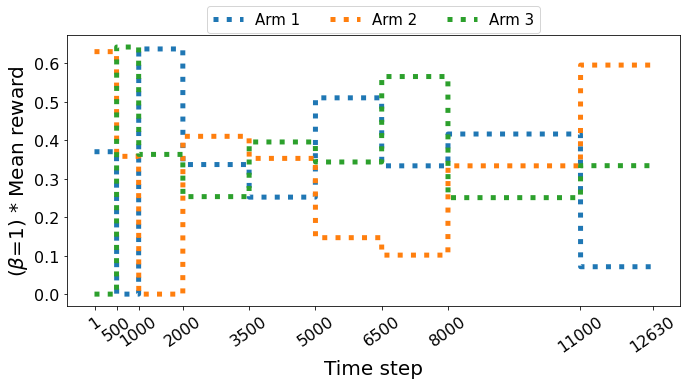

In [38]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


### Non-stationarity in costs

In [39]:
cost_change_points = [3000, 5000, 7000, 9000, 11000]
interval_count = len(cost_change_points) + 1

In [40]:
cost_means_range = [0.05, 0.1]

In [41]:
COSTS_RANGE_SIZE = cost_means_range[1] - cost_means_range[0]

In [42]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [
    np.random.uniform(
        cost_means_range[0], cost_means_range[1], size=(new_contexts.shape[1],)
    ) for i in range(interval_count)
]

In [43]:
interval_means

[array([0.06872701, 0.09753572, 0.0865997 , 0.07993292]),
 array([0.05780093, 0.05779973, 0.05290418, 0.09330881]),
 array([0.08005575, 0.08540363, 0.05102922, 0.09849549]),
 array([0.09162213, 0.06061696, 0.05909125, 0.05917023]),
 array([0.06521211, 0.07623782, 0.07159725, 0.06456146]),
 array([0.08059264, 0.05697469, 0.06460723, 0.06831809])]

In [44]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [45]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

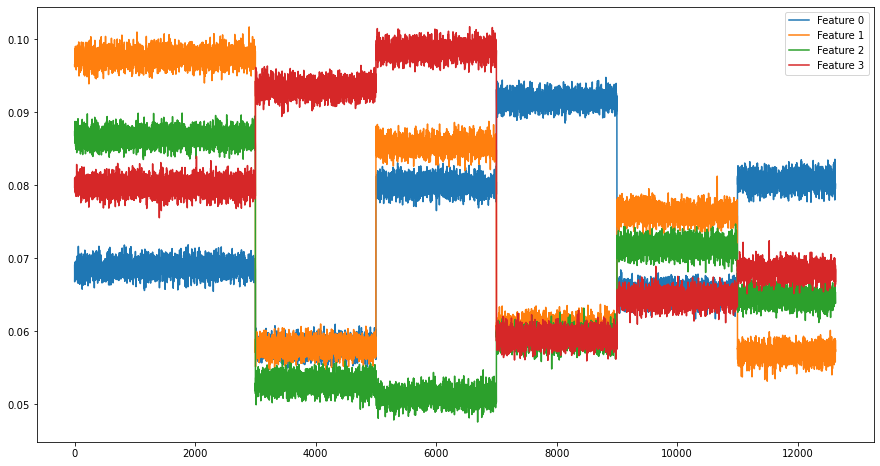

In [46]:
plot_costs(get_costs(), new_contexts.shape[0])

In [47]:
costs_obj = get_costs()

In [48]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [49]:
costs_vector.shape

(12630, 4)

## Save mean costs for plotting

In [50]:
full_cost_change_points = [0] + cost_change_points + [new_contexts.shape[0]]
cost_stationarity_regions = []
for a, b in zip(full_cost_change_points, full_cost_change_points[1:]):
    cost_stationarity_regions.append(slice(a,b))

In [51]:
mean_costs = np.zeros(costs_vector.shape)
for i, region in enumerate(cost_stationarity_regions):
    for feature in range(new_contexts.shape[1]):
        
        # For plotting
        mean_costs[region, feature] = (
            np.ones(costs_vector[region, feature].shape) * interval_means[i][feature]
        )

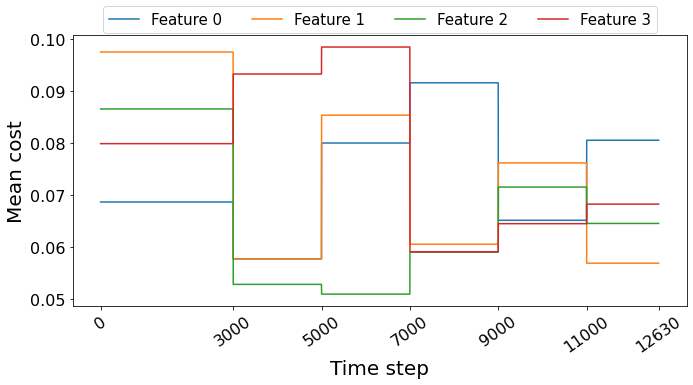

In [52]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for feature in range(new_contexts.shape[1]):
    ax.plot(mean_costs[:, feature], label=f"Feature {feature}")

extraticks = full_cost_change_points
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"Mean cost", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})

plt.show()

## Plot expected reward minus sum of costs

In [53]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

Min expected gain for arm 1: -0.3382907395001041
Min expected gain for arm 2: -0.339053628268038
Min expected gain for arm 3: -0.33885757633632974


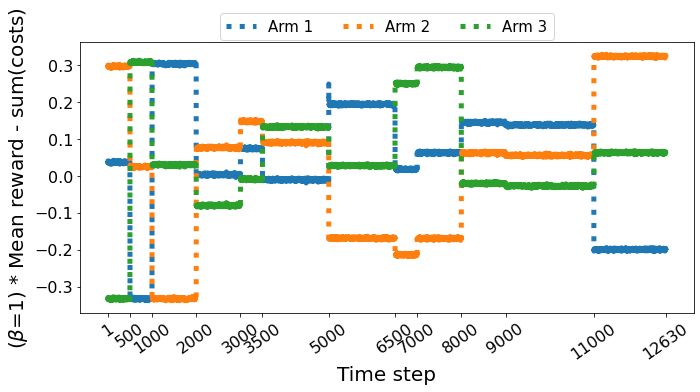

In [54]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = all_change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


In [55]:
def plot_gains(gain_dict, reward_change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    
    max_vline=0
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    plt.vlines(reward_change_points, ymin=0, ymax=max_vline, linestyle=':', alpha=0.4)
    
    extraticks = all_change_point_values
    plt.xticks(extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

## Testing on non-stationary data

In [56]:
NUM_OF_TRIALS = 3000#all_contexts.shape[0]
NUM_REPETITIONS = 1

In [57]:
np.random.seed(42)

In [58]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random = evaluation.evaluate_on_synthetic_data(
        p_random,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_random
    
gain_random = np.mean(gains, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Beta = 1
Total gain: 993.0
	Total reward: 993.0
	Total cost: 0
Execution time: 0.0s
Average gain: 993.0


In [59]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.01, n_arms=new_rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.01)
Beta = 1
Total gain: 1327.0
	Total reward: 1327.0
	Total cost: 0
Execution time: 0.0s
Average gain: 1327.0


In [60]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=new_rewards.shape[1],
            alpha=0.5,
        )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_ucb

gain_ucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.5)
Beta = 1
Total gain: 1570.0
	Total reward: 1570.0
	Total cost: 0
Execution time: 0.0s
Average gain: 1570.0


In [61]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.7,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_linucb

gain_linucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.7)
Beta = 1
Total gain: 803.7538790872026
	Total reward: 1802.0
	Total cost: 998.2461209127982
Execution time: 0.2s
Average gain: 803.7538790872026


In [62]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.5,
        omega=100,
        delta=0.1,
    )


    gain_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    change_points = ps_linucb.change_points
    gains[i, :] = gain_pslinucb

gain_pslinucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.5, omega=100, delta=0.1)
Beta = 1
Total gain: 1247.7538790872031
	Total reward: 2246.0
	Total cost: 998.2461209127982
Execution time: 0.3s
Average gain: 1247.7538790872031


In [63]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.03,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_simoos

gain_simoos = np.mean(gains, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0014338493347167969 seconds
Trial 0, time 2022-05-16 18:28:19.979434
Trial 500, time 2022-05-16 18:28:27.451364
Trial 1000, time 2022-05-16 18:28:27.834102
Trial 1500, time 2022-05-16 18:28:28.652134
Trial 2000, time 2022-05-16 18:28:29.393467
Trial 2500, time 2022-05-16 18:28:31.517756
SimOOS (beta=1, delta=0.03)
Beta = 1
Total gain: 882.2951444913452
	Total reward: 1203.0
	Total cost: 320.70485550865453
Execution time: 11.7s
Took 11.666830062866211 seconds
Average gain: 882.2951444913452


In [64]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1 = algorithms.Algorithm1(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta=BETA,
        delta=0.3,
        window_length=250,
        costs_range=COSTS_RANGE_SIZE,
        
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1 = evaluation.evaluate_on_synthetic_data(
            p_alg1,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
        gains[i, :] = gain_alg1

gain_alg1 = np.mean(gains, axis=0)
print(f"Average gain: {gain_alg1[-1]}")

Took 0.0015730857849121094 seconds
Round 0, time 2022-05-16 18:28:31.685139
Round 500, time 2022-05-16 18:29:11.144971
Round 1000, time 2022-05-16 18:29:50.764672
Round 1500, time 2022-05-16 18:30:30.933220
Round 2000, time 2022-05-16 18:31:11.880767
Round 2500, time 2022-05-16 18:31:49.525593
Algorithm1 (beta=1, delta=0.3, w=250)
Beta = 1
Total gain: 1179.9628804615245
	Total reward: 1500.0
	Total cost: 320.0371195384773
Execution time: 3.9m
Took 235.70537114143372 seconds
Average gain: 1179.9628804615245


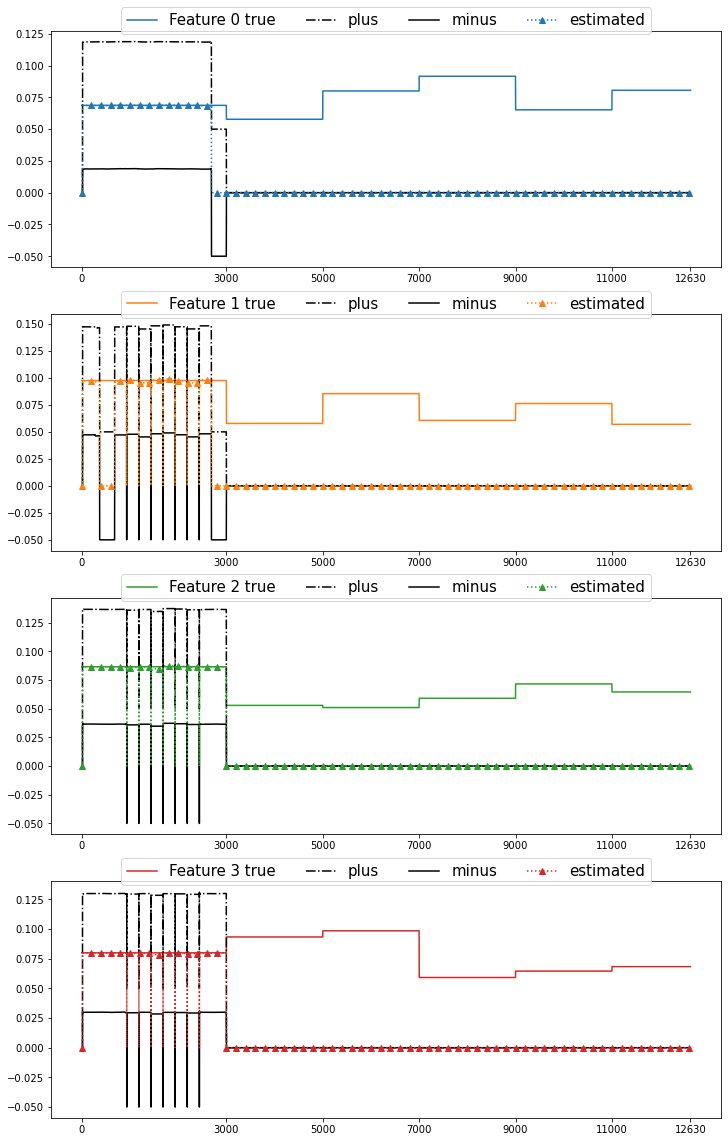

In [65]:
fig, axes = plt.subplots(new_contexts.shape[1], 1, figsize=(12, 5*new_contexts.shape[1]))

extraticks = full_cost_change_points

for feature, ax in enumerate(axes):
    ax.plot(mean_costs[:, feature], label=f"Feature {feature} true", color=plt.cm.tab10(feature))
    ax.plot(p_alg1.costs_plus_bound[:, feature] , linestyle='-.', color='k', label='plus')
    ax.plot(p_alg1.costs_minus_bound[:, feature] , color='k', label='minus')
    ax.plot(
        p_alg1.c_hats[:, feature], marker='^', markevery=200, linestyle=':',
        color=plt.cm.tab10(feature), label='estimated'
    )

    lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})

    ax.set_xticks(extraticks)
    
plt.show()

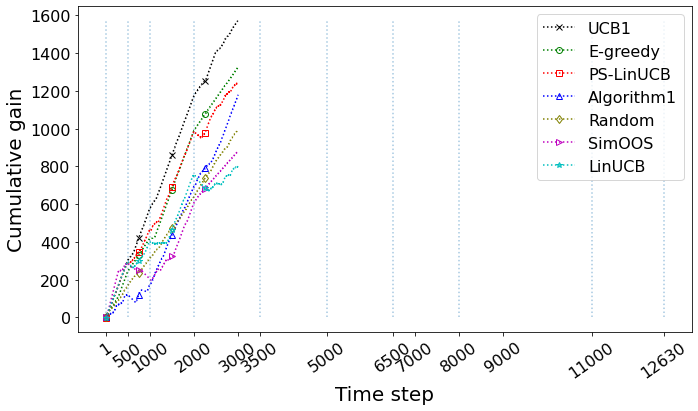

In [66]:
plot_gains(
    {
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
    },
    reward_change_points=change_point_values,
)


In [67]:
p_alg1.selected_context_SimOOS

array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [68]:
list((p_alg1.costs_plus_bound - p_alg1.costs_minus_bound)[-2000:]/2)

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 

In [85]:
list(enumerate(zip(p_alg1.cost_conf_int, p_alg1.N_t_fs)))[2000:]

[(2000,
  (array([0.24353505, 2.9627317 , 2.9627317 , 2.9627317 ]),
   array([148.,   1.,   1.,   1.]))),
 (2001,
  (array([0.24271644, 2.9627317 , 2.9627317 , 2.9627317 ]),
   array([149.,   1.,   1.,   1.]))),
 (2002,
  (array([0.24271644, 2.9627317 , 2.9627317 , 2.9627317 ]),
   array([149.,   1.,   1.,   1.]))),
 (2003,
  (array([0.24190603, 2.9627317 , 2.9627317 , 2.9627317 ]),
   array([150.,   1.,   1.,   1.]))),
 (2004,
  (array([0.24110369, 2.9627317 , 2.9627317 , 2.9627317 ]),
   array([151.,   1.,   1.,   1.]))),
 (2005,
  (array([0.24190603, 2.9627317 , 2.9627317 , 2.9627317 ]),
   array([150.,   1.,   1.,   1.]))),
 (2006,
  (array([0.24190603, 2.9627317 , 2.9627317 , 2.9627317 ]),
   array([150.,   1.,   1.,   1.]))),
 (2007,
  (array([0.24190603, 2.9627317 , 2.9627317 , 2.9627317 ]),
   array([150.,   1.,   1.,   1.]))),
 (2008,
  (array([0.24190603, 2.9627317 , 2.9627317 , 2.9627317 ]),
   array([150.,   1.,   1.,   1.]))),
 (2009,
  (array([0.24190603, 2.9627317 , 2.96